# Simple CNN for compare default parameters in further applications
#### Previous adversial ensemble network will be created in another file

In [12]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import Counter

Define runtime parameter

In [22]:
n_epochs = 20
batch_size_train = 32
batch_size_test = 32
log_interval = 10

random_seed = 1337
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

Load MNIST Dataset from torchvision

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True, drop_last=True,worker_init_fn=random_seed)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True,drop_last=True,worker_init_fn=random_seed)

In [5]:
print(train_loader.dataset.train_data.size())
print(test_loader.dataset.test_data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


F:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
F:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [6]:
nr_train = np.array([])
for i, (data, target) in enumerate(train_loader):
    nr_train=np.append(nr_train, target.cpu().detach().numpy())

nr_test = np.array([])
for i, (data, target) in enumerate(test_loader):
    nr_test=np.append(nr_test, target.cpu().detach().numpy())

In [7]:
Counter(np.sort(nr_train))

Counter({0.0: 5923,
         1.0: 6742,
         2.0: 5958,
         3.0: 6131,
         4.0: 5842,
         5.0: 5421,
         6.0: 5918,
         7.0: 6265,
         8.0: 5851,
         9.0: 5949})

In [8]:
Counter(np.sort(nr_test))

Counter({0.0: 979,
         1.0: 1133,
         2.0: 1030,
         3.0: 1009,
         4.0: 980,
         5.0: 890,
         6.0: 956,
         7.0: 1027,
         8.0: 973,
         9.0: 1007})

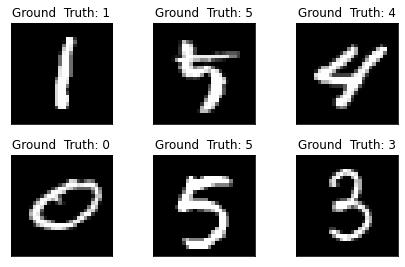

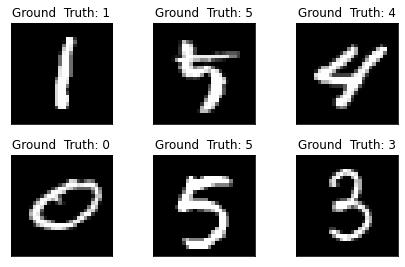

In [9]:
examples = enumerate(test_loader,start=0)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground  Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [51]:
class simple_net(nn.Module):
    def __init__(self):
        super(simple_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [88]:

learning_rate = 0.015
momentum = 0.5
network = simple_net()
#device = "cuda:0"
#network.to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate, weight_decay=0.0005)

In [89]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [82]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [83]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.cross_entropy(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [90]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-51-751d87e5e9f5>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
F:\Anaconda\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3178, Accuracy: 892/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.375317
Train Epoch: 1 [320/60000 (1%)]	Loss: 2.292893
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.324321
Train Epoch: 1 [960/60000 (2%)]	Loss: 2.295269
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.309279
Train Epoch: 1 [1600/60000 (3%)]	Loss: 2.230514
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.035310
Train Epoch: 1 [2240/60000 (4%)]	Loss: 1.988423
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.839652
Train Epoch: 1 [2880/60000 (5%)]	Loss: 1.815822
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.055184
Train Epoch: 1 [3520/60000 (6%)]	Loss: 1.699499
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.612607
Train Epoch: 1 [4160/60000 (7%)]	Loss: 1.733174
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.931793
Train Epoch: 1 [4800/60000 (8%)]	Loss: 1.585195
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.630988
Train Epoch: 1 [5440/60000 (9%)]	Loss: 1.761583
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.967279
Train Epoch: 1 [6080/60000 (10%)]	Los

## SGD

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

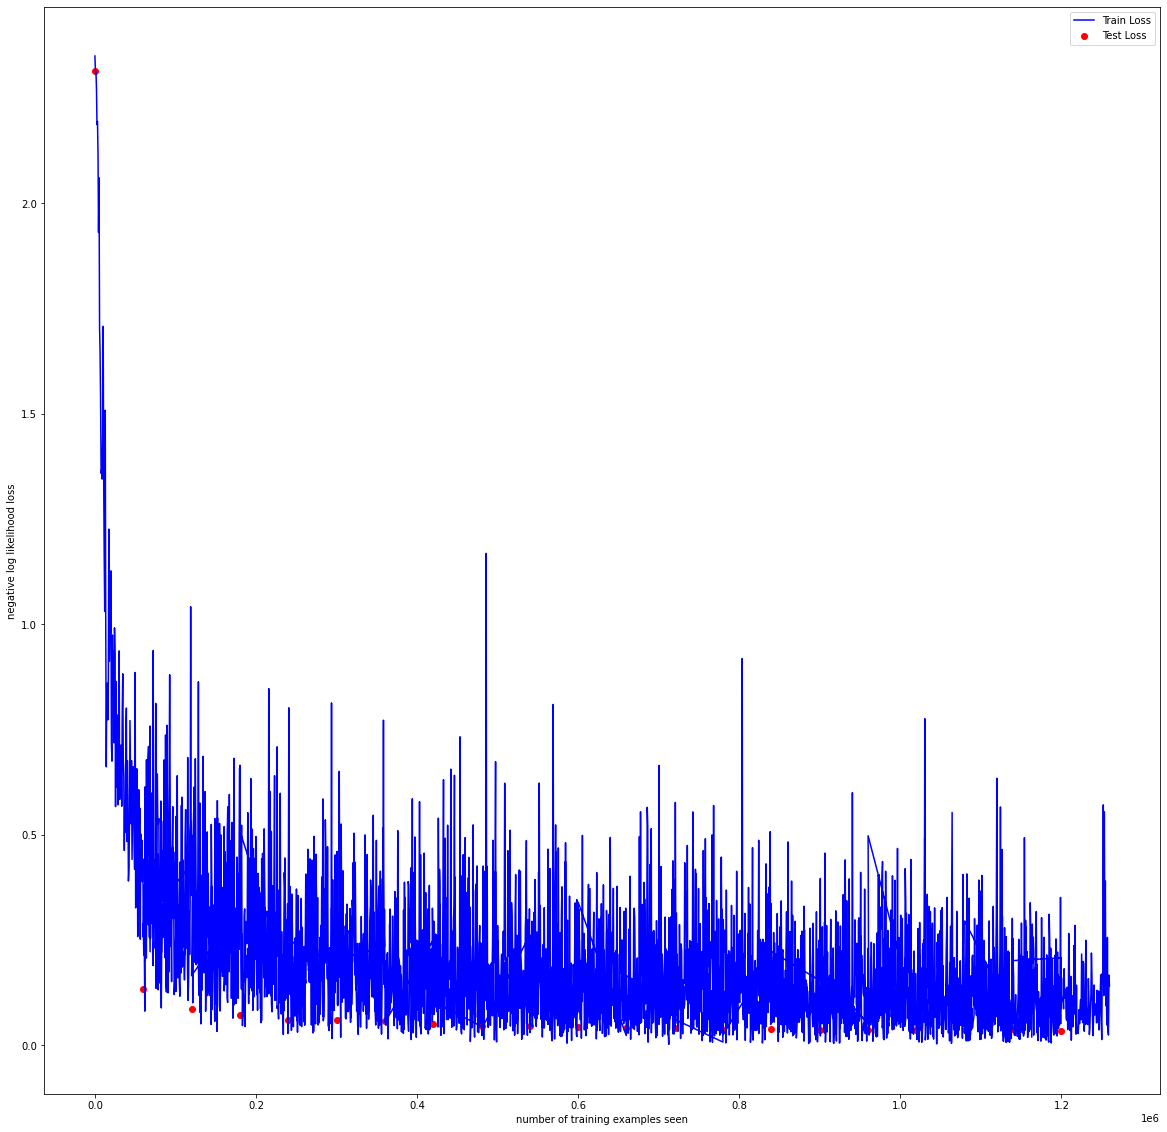

In [29]:
fig = plt.figure()
plt.figure(figsize=(20,20))
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

# Documentation

##### ___Params___
##### Epochs: 20
##### b_size = 32
##### Optimizer = SGD
##### Momentum = 0.5
##### LR = 0.01
##### ___RESULTS___
##### Train Epoch: 20 [59840/60000 (100%)]	Loss: 0.141315
##### Test set: Avg. loss: 0.0337, Accuracy: 9881/10000 (99%)


## ADAM

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

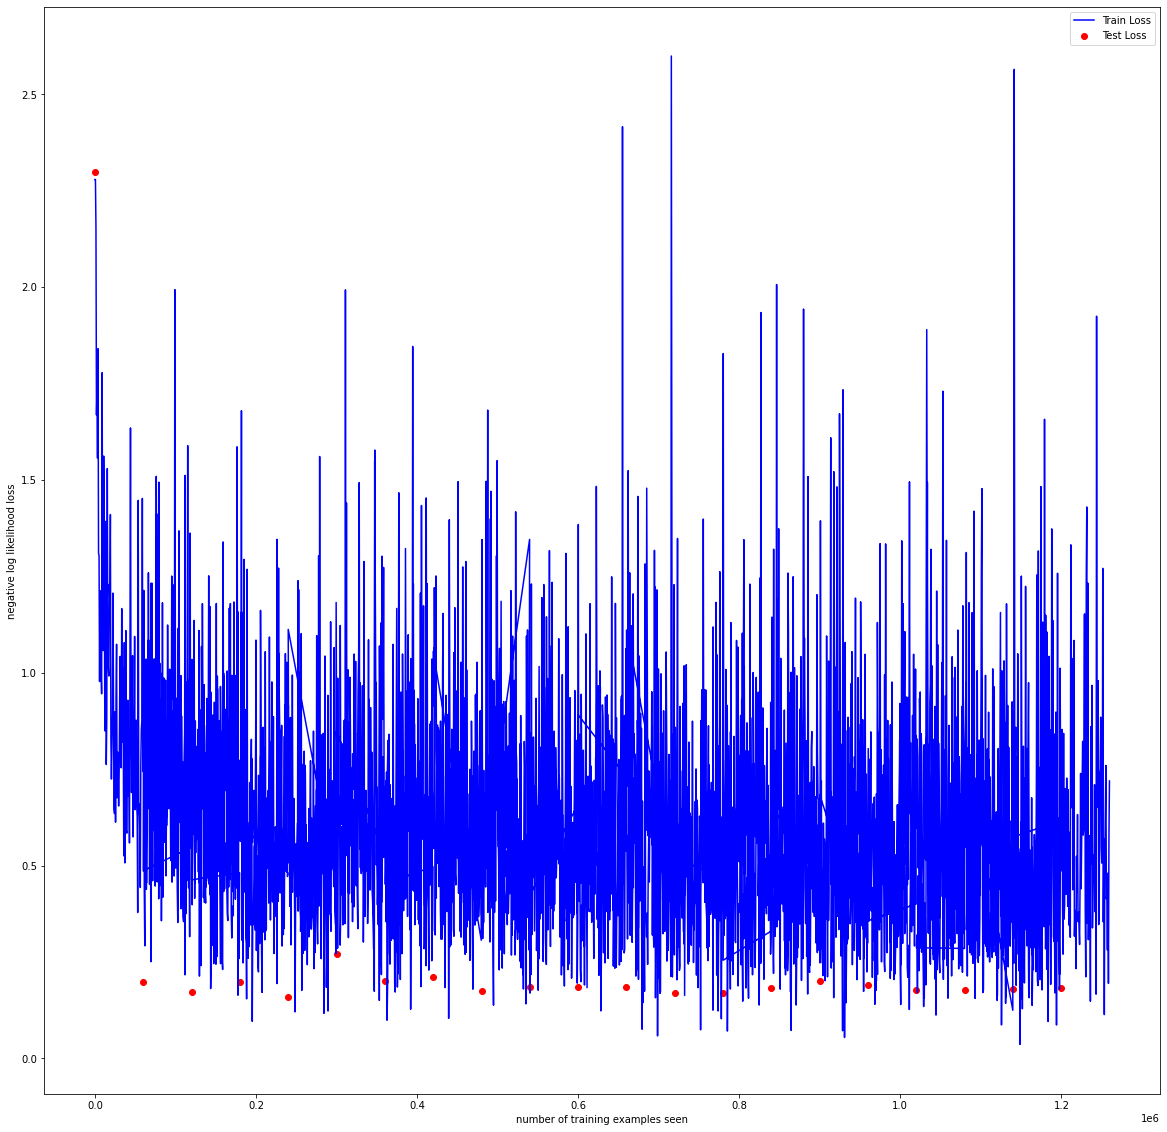

In [48]:
fig = plt.figure()
plt.figure(figsize=(20,20))
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig



# Documentation

##### ___Params___
##### Epochs: 20
##### b_size = 32
##### Optimizer = ADAM
##### LR = 0.01
##### ___RESULTS___
##### Train Epoch: 20 [59840/60000 (100%)]	Loss: 0.719241
##### Test set: Avg. loss: 0.1823, Accuracy: 9468/10000 (95%)